In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls /content/drive/MyDrive
!unzip "/content/drive/MyDrive/data_m_48.zip"

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 26 10:34:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset

In [11]:
train_dir = 'data/train'
val_dir = 'data/test'

batch_size = 64
num_epoch = 50

img_w=48
img_h=48

data_loader=ImageDataGenerator(rescale=1/255,)

train_dataset=data_loader.flow_from_directory(train_dir,target_size=(img_h,img_w),batch_size=batch_size,color_mode="grayscale",class_mode='categorical',shuffle=True,seed=42)
val_dataset=data_loader.flow_from_directory(val_dir,target_size=(img_h,img_w),batch_size=batch_size,color_mode="grayscale",class_mode='categorical',shuffle=True,seed=42)


print(train_dataset.class_indices)

Found 41310 images belonging to 3 classes.
Found 12354 images belonging to 3 classes.
{'happy': 0, 'neutral': 1, 'sad': 2}


# Define Model v1

In [16]:
# with tf.device("gpu:0"):
model = Sequential([
Input((img_h,img_w,1)),
Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'), #, input_shape=(300,300,3)
MaxPooling2D(pool_size=(2, 2)),
Conv2D(48, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(len(train_dataset.class_indices), activation='softmax')
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 48)        13872     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 48)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        27712     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)         

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('FacER.weight', monitor='val_loss', mode='min', save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])
history = model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=val_dataset,
        callbacks=[es, mc])

model.save_weights('FacER.weight')

Epoch 1/50
646/646 [==============================] - 16s 24ms/step - loss: 1.0877 - accuracy: 0.3838 - val_loss: 1.0215 - val_accuracy: 0.4869
INFO:tensorflow:Assets written to: FacER.weight/assets
Epoch 2/50
646/646 [==============================] - 15s 24ms/step - loss: 0.9745 - accuracy: 0.5211 - val_loss: 0.8149 - val_accuracy: 0.6204
INFO:tensorflow:Assets written to: FacER.weight/assets
Epoch 3/50
646/646 [==============================] - 15s 23ms/step - loss: 0.8048 - accuracy: 0.6315 - val_loss: 0.6947 - val_accuracy: 0.6930
INFO:tensorflow:Assets written to: FacER.weight/assets
Epoch 4/50
646/646 [==============================] - 15s 24ms/step - loss: 0.7212 - accuracy: 0.6771 - val_loss: 0.6140 - val_accuracy: 0.7345
INFO:tensorflow:Assets written to: FacER.weight/assets
Epoch 5/50
646/646 [==============================] - 16s 25ms/step - loss: 0.6426 - accuracy: 0.7243 - val_loss: 0.5303 - val_accuracy: 0.7774
INFO:tensorflow:Assets written to: FacER.weight/assets
Epoch

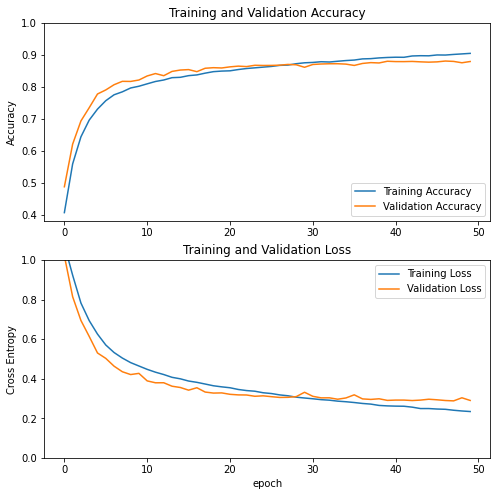

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Define Model v2

In [22]:
# with tf.device("gpu:0"):
model = Sequential([
Input((img_h,img_w,1)),
Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'), #, input_shape=(300,300,3)
MaxPooling2D(pool_size=(2, 2)),
Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),


Flatten(),
Dense(256, activation='relu'),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(len(train_dataset.class_indices), activation='softmax')
])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 128)        

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('FacER_v2.weight', monitor='val_loss', mode='min', save_best_only=True)
num_epoch=50
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])
history = model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=val_dataset,
        callbacks=[es, mc])

model.save_weights('FacER_v2.weight')

Epoch 1/50
646/646 [==============================] - 15s 23ms/step - loss: 0.9326 - accuracy: 0.5739 - val_loss: 0.7587 - val_accuracy: 0.6721
INFO:tensorflow:Assets written to: FacER_v2.weight/assets
Epoch 2/50
646/646 [==============================] - 15s 23ms/step - loss: 0.7661 - accuracy: 0.6622 - val_loss: 0.6195 - val_accuracy: 0.7368
INFO:tensorflow:Assets written to: FacER_v2.weight/assets
Epoch 3/50
646/646 [==============================] - 15s 23ms/step - loss: 0.6428 - accuracy: 0.7215 - val_loss: 0.5526 - val_accuracy: 0.7641
INFO:tensorflow:Assets written to: FacER_v2.weight/assets
Epoch 4/50
646/646 [==============================] - 15s 23ms/step - loss: 0.5760 - accuracy: 0.7546 - val_loss: 0.4908 - val_accuracy: 0.7927
INFO:tensorflow:Assets written to: FacER_v2.weight/assets
Epoch 5/50
646/646 [==============================] - 15s 23ms/step - loss: 0.5223 - accuracy: 0.7765 - val_loss: 0.4584 - val_accuracy: 0.8048
INFO:tensorflow:Assets written to: FacER_v2.weig

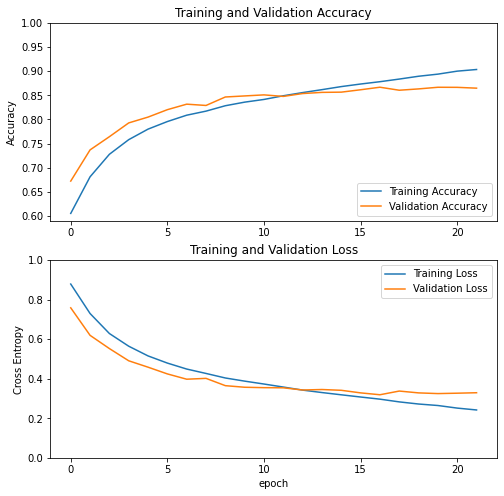

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Define Model v3

In [28]:
# with tf.device("gpu:0"):
model = Sequential([
Input((img_h,img_w,1)),
Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'), #, input_shape=(300,300,3)
MaxPooling2D(pool_size=(2, 2)),
Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(256, activation='relu'),
Dropout(0.25),
Dense(len(train_dataset.class_indices), activation='softmax')
])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 6, 6, 256)        

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('FacER_v3.weight', monitor='val_loss', mode='min', save_best_only=True)
num_epoch=50
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])
history = model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=val_dataset,Q
        callbacks=[es, mc])

model.save_weights('FacER_v3.weight')

Epoch 1/50
646/646 [==============================] - 16s 24ms/step - loss: 1.0734 - accuracy: 0.4015 - val_loss: 0.8339 - val_accuracy: 0.6195
INFO:tensorflow:Assets written to: FacER_v3.weight/assets
Epoch 2/50
646/646 [==============================] - 15s 23ms/step - loss: 0.7708 - accuracy: 0.6620 - val_loss: 0.6287 - val_accuracy: 0.7301
INFO:tensorflow:Assets written to: FacER_v3.weight/assets
Epoch 3/50
646/646 [==============================] - 15s 23ms/step - loss: 0.5875 - accuracy: 0.7486 - val_loss: 0.5005 - val_accuracy: 0.7862
INFO:tensorflow:Assets written to: FacER_v3.weight/assets
Epoch 4/50
646/646 [==============================] - 15s 23ms/step - loss: 0.5010 - accuracy: 0.7895 - val_loss: 0.4484 - val_accuracy: 0.8134
INFO:tensorflow:Assets written to: FacER_v3.weight/assets
Epoch 5/50
646/646 [==============================] - 15s 23ms/step - loss: 0.4489 - accuracy: 0.8124 - val_loss: 0.4211 - val_accuracy: 0.8222
INFO:tensorflow:Assets written to: FacER_v3.weig

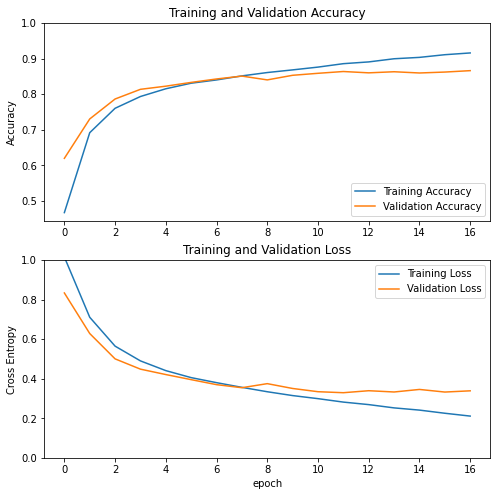

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# MovbileNet V2

In [63]:
train_dir = 'data/train'
val_dir = 'data/test'

batch_size = 64
num_epoch = 50

img_w=96
img_h=96

data_loader=ImageDataGenerator(rescale=1/255,)

train_dataset=data_loader.flow_from_directory(train_dir,target_size=(img_h,img_w),batch_size=batch_size,color_mode="rgb",class_mode='categorical',shuffle=True,seed=666)
val_dataset=data_loader.flow_from_directory(val_dir,target_size=(img_h,img_w),batch_size=batch_size,color_mode="rgb",class_mode='categorical',shuffle=True,seed=666)


print(train_dataset.class_indices)

Found 41310 images belonging to 3 classes.
Found 12354 images belonging to 3 classes.
{'happy': 0, 'neutral': 1, 'sad': 2}


In [66]:
import tensorflow as tf
IMG_SHAPE = (img_h, img_w, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(len(train_dataset.class_indices), activation='softmax')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('MobileNetV2_second.weight', monitor='val_loss', mode='min', save_best_only=True)
num_epoch=50
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])
history = model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=val_dataset,
        callbacks=[es, mc])

# model.save_weights('MobileNetV2.weight')

Epoch 1/50
646/646 [==============================] - 50s 70ms/step - loss: 0.6662 - accuracy: 0.7051 - val_loss: 0.7583 - val_accuracy: 0.7260
INFO:tensorflow:Assets written to: MobileNetV2_second.weight/assets
Epoch 2/50
646/646 [==============================] - 45s 70ms/step - loss: 0.2474 - accuracy: 0.9010 - val_loss: 0.5795 - val_accuracy: 0.7744
INFO:tensorflow:Assets written to: MobileNetV2_second.weight/assets
Epoch 3/50
646/646 [==============================] - 45s 69ms/step - loss: 0.1471 - accuracy: 0.9451 - val_loss: 0.7725 - val_accuracy: 0.6905
Epoch 4/50
646/646 [==============================] - 44s 69ms/step - loss: 0.0963 - accuracy: 0.9679 - val_loss: 0.8804 - val_accuracy: 0.6946
Epoch 5/50
646/646 [==============================] - 44s 68ms/step - loss: 0.0668 - accuracy: 0.9763 - val_loss: 1.1299 - val_accuracy: 0.6862
Epoch 6/50
646/646 [==============================] - 45s 70ms/step - loss: 0.0462 - accuracy: 0.9843 - val_loss: 1.0192 - val_accuracy: 0.6815


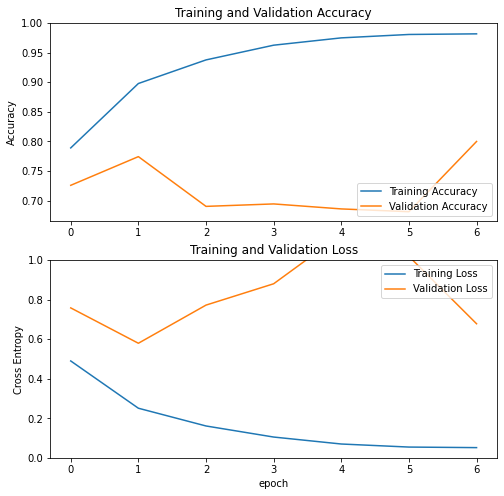

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [72]:
base_model.trainable = True

# 기본 모델에 몇 개의 층이 있는지 확인 합니다.
print("Number of layers in the base model: ", len(base_model.layers))

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001, decay=1e-6), metrics=['accuracy'])

Number of layers in the base model:  154


In [73]:
fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[es, mc])

Epoch 7/36
646/646 [==============================] - 32s 45ms/step - loss: 0.1146 - accuracy: 0.9566 - val_loss: 0.4912 - val_accuracy: 0.8528
INFO:tensorflow:Assets written to: MobileNetV2_second.weight/assets
Epoch 8/36
646/646 [==============================] - 28s 43ms/step - loss: 0.0731 - accuracy: 0.9737 - val_loss: 0.4508 - val_accuracy: 0.8701
INFO:tensorflow:Assets written to: MobileNetV2_second.weight/assets
Epoch 9/36
646/646 [==============================] - 28s 44ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.4546 - val_accuracy: 0.8737
Epoch 10/36
646/646 [==============================] - 28s 44ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.4702 - val_accuracy: 0.8765
Epoch 11/36
646/646 [==============================] - 28s 43ms/step - loss: 0.0260 - accuracy: 0.9938 - val_loss: 0.4858 - val_accuracy: 0.8759
Epoch 12/36
646/646 [==============================] - 28s 43ms/step - loss: 0.0204 - accuracy: 0.9956 - val_loss: 0.5051 - val_accuracy: 0.87

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

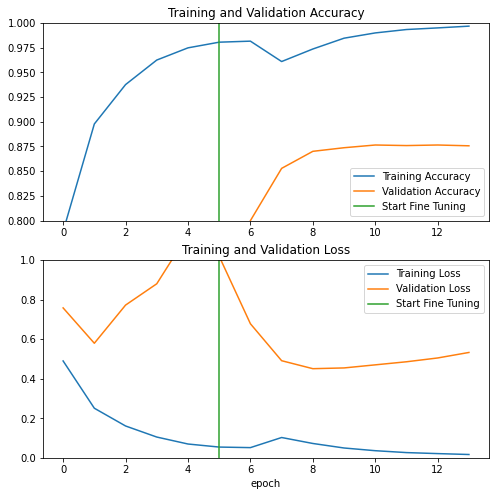

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()